In [167]:
import pandas as pd
import seaborn as sns
from nltk import word_tokenize, download
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

In [168]:
download('stopwords')
download('punkt')
!pip install xlsxwriter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [169]:
# !pip install tensorflow==1.15
# !pip install tensorflow_hub
# !pip install tensorflow_text==1.15rc0

# import tensorflow as tf
# import tensorflow_hub as hub
import numpy as np


## Lectura de datos

In [170]:
data_train = pd.read_csv('/content/drive/My Drive/Rappi challenge/train_challenge.csv')

In [171]:
data_train.head(2)

,name,description,maker,trademark
0,Cerveza Otro Mundo 500 Ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo
1,Vino San Telmo Varietales X750Ml.,Vino San Telmo Varietales X750Ml.,NaN,San Telmo


In [172]:
# Revisar tipos de datos y non-null columns

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10000 non-null  object
 1   description  10000 non-null  object
 2   maker        3418 non-null   object
 3   trademark    9965 non-null   object
dtypes: object(4)
memory usage: 312.6+ KB


## Preprocesamiento

In [173]:
# Revisar que tan iguales son la columna name y description

print("El {} %  de los registros entre name y description son iguales" \
      .format(sum(data_train['name'] == data_train['description'])*100/len(data_train)))

El 90.22 %  de los registros entre name y description son iguales


In [174]:
# Lenar los 35 valores faltantes de la columna trademark con una variable dummy

data_train['trademark'] = data_train['trademark'].fillna('N/A')

In [175]:
# Eliminar stop words de una lista

def remove_stopwords(words):
    """Eliminar stop words de una lista tokenizada de palabras"""
    new_words = []
    for word in words:
        if word not in stopwords.words('spanish'):
            new_words.append(word)
    return new_words

In [176]:
# Eliminar los guiones que los utilizan como separador de palabras. Puntos, guiones y comas que no son decimales

def remove_punctuation(words):
    """Eliminar los guiones que los utilizan como separador de palabras. Puntos, guiones y comas que no son decimales"""
    new_words = []
    for word in words:
        new_word = word.lower() # Eliminar mayusculas
        new_word = re.sub(r"([a-z])\-([a-z])", r"\1 \2", new_word)  # Eliminar los guiones que los utilizan como separador de palabras
        new_word = re.sub(r"([a-z]|)([0-9]|[0-9][0-9]|[0-9][0-9][0-9]|[0-9][0-9][0-9][0-9])([a-z])", r"\1 \2 \3", new_word) # Separar los numeros de letras (150gr) --> (150 gr)
        if ((new_word != '') & (new_word != ',') & (new_word != '.') & (new_word != '-')):  # Eliminar puntos y comas que no son decimales
            new_words.append(new_word)
    return new_words

In [177]:
# Transformar la palabra a su raiz

from nltk.stem import SnowballStemmer

def stem_words(words):
    """Transformar la palabra a su raiz de una lista tokenizada de palabras"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [178]:
def normalize(words):
    words = word_tokenize(words)
    words = remove_punctuation(words)
    words = ' '.join(words)

    words = word_tokenize(words)
  
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = ' '.join(words)
    return words

In [179]:
# Aplicar las transformaciones a la columna 'name'

data_train['name'] = data_train['name'].apply(normalize)

In [180]:
# Crear una columna con la descripcion y marca

data_train['name + trade_mark'] = data_train['name'] + ' ' + data_train['trademark']

In [181]:
# Eliminar duplicados

data_train.drop_duplicates('name + trade_mark', inplace=True)

In [182]:
data_train.head(10)

,name,description,maker,trademark,name + trade_mark
0,cerveza mundo 500 ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza mundo 500 ml Otro Mundo
1,vino san telmo varietales x 750 ml,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x 750 ml San Telmo
2,mayonesa natura 1000 cc,Mayonesa Natura con jugo de limon sachet x 100...,gallega,Natura,mayonesa natura 1000 cc Natura
3,brahma chopp 354 cc x 6,Brahma Chopp 354cc x 6,NaN,Brahma,brahma chopp 354 cc x 6 Brahma
4,mayonesa hellmanns light doypack 237 gr,Mayonesa HellmannS Light Doypack 237 Gr,NaN,Hellmann´S,mayonesa hellmanns light doypack 237 gr Hellma...
5,vino cardos sauv blanco,VINO BLANCO LOS CARDOS SAUVIGNON 750 CC,NaN,LOS CARDOS,vino cardos sauv blanco LOS CARDOS
6,postre georgalos nucrem chocolatados 170 gr,Postre Georgalos Nucrem Chocolatados 170 Gr,NaN,Georgalos,postre georgalos nucrem chocolatados 170 gr Ge...
7,salchichón piccolo calchaqui morrones 240 g,Salchichón Piccolo Calchaqui Con Morrones 240 g,La Piamontesa\t,Calchaqui,salchichón piccolo calchaqui morrones 240 g Ca...
8,galletitas obleas rhodesia agrupado 22 gr x 4 u,Galletitas Obleas Rhodesia Agrupado 22 Gr X 4 U,NaN,Rhodesia,galletitas obleas rhodesia agrupado 22 gr x 4 ...
9,aceite oliva natura extra virgen clásico 500 ml,Aceite De Oliva Natura Extra Virgen Clásico 50...,NaN,Natura,aceite oliva natura extra virgen clásico 500 m...


In [183]:
len(data_train)

6170

# Vectorización

## Tfidf

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
data_tfidf = data_train.copy()    

In [186]:
corpus = data_tfidf['name']
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X_tfidf.shape)


['000', '10', '100', '1000', '101', '105', '110', '1100', '1125', '113', '115', '116', '118', '12', '120', '125', '126', '127', '128', '13', '130', '1300', '135', '136', '14', '140', '141', '143', '144', '145', '148', '15', '150', '1500', '155', '157', '158', '16', '160', '162', '163', '164', '165', '166', '1664', '167', '170', '171', '173', '175', '177', '18', '180', '185', '187', '1887', '1890', '1895', '19', '190', '1906', '195', '198', '1ª', '20', '200', '2005', '2007', '2009', '2010', '2012', '2013', '2015', '204', '205', '21', '210', '215', '216', '217', '22', '220', '224', '225', '226', '227', '228', '23', '230', '232', '235', '237', '238', '24', '240', '242', '25', '250', '255', '258', '26', '264', '269', '27', '270', '275', '276', '28', '280', '283', '284', '285', '29', '290', '2ª', '30', '300', '305', '31', '310', '315', '320', '326', '33', '330', '332', '335', '336', '33º', '34', '340', '346', '35', '350', '354', '355', '36', '360', '368', '369', '37', '370', '375', '38', '3

<BarContainer object of 50 artists>

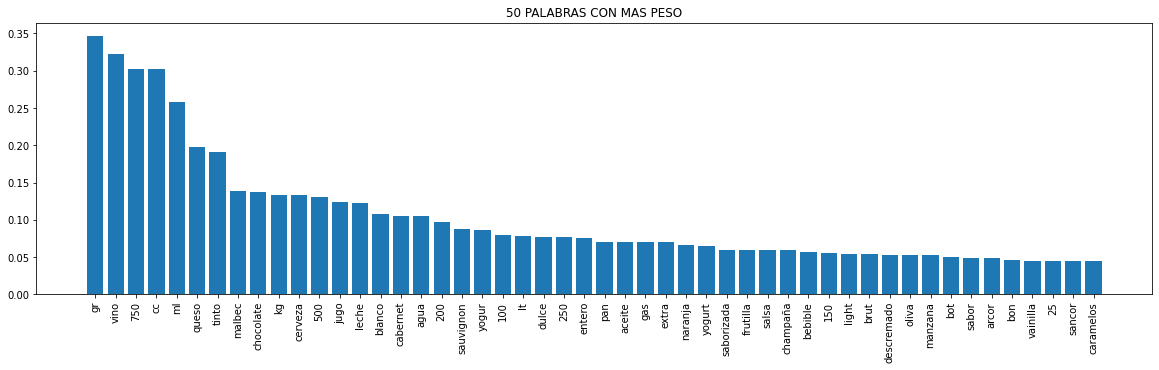

In [187]:
feature_importances = vectorizer.transform([" ".join(corpus.to_list())])
max_indices = feature_importances.toarray()[0].argsort()[-50:][::-1]
max_words = [(vectorizer.get_feature_names()[i],feature_importances.toarray()[0][i]) for i in max_indices]

plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.title("50 PALABRAS CON MAS PESO")
plt.bar(*zip(*max_words))

## Embeddings

# Clustering

## K means

In [188]:
from sklearn.cluster import KMeans
import numpy as np

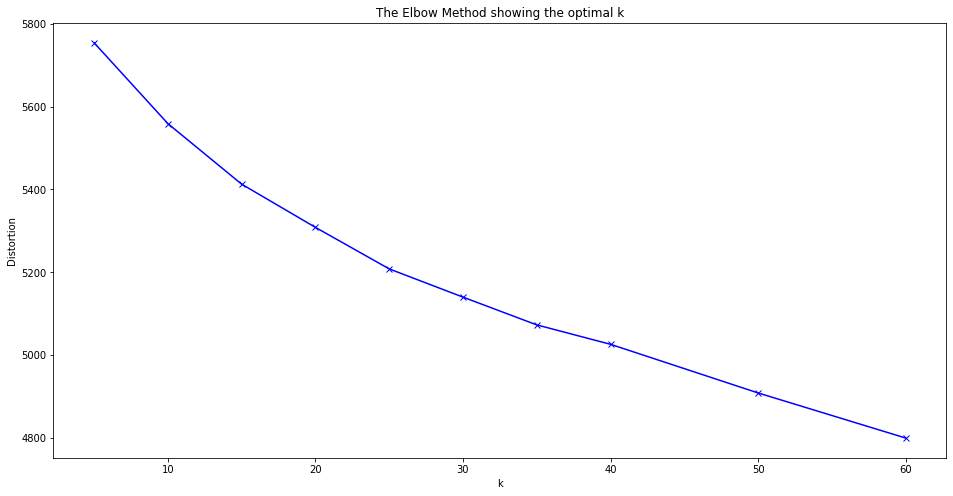

In [189]:
# Eligiendo el numero de clusters
distortions = []
K = (5,10,15,20,25,30,35,40,50,60)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_tfidf)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

###  Using tfidf vectorization

In [190]:
kmeans = KMeans(n_clusters=30, random_state=10).fit(X_tfidf)
kmeans.labels_


array([17, 25, 15, ...,  2,  1,  2], dtype=int32)

In [191]:
data_tfidf['cluster'] = kmeans.labels_

In [192]:
data_tfidf.head(2)

,name,description,maker,trademark,name + trade_mark,cluster
0,cerveza mundo 500 ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza mundo 500 ml Otro Mundo,17
1,vino san telmo varietales x 750 ml,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x 750 ml San Telmo,25


In [193]:
#data_tfidf[data_tfidf['cluster']==10][:60]

In [194]:
categorias = {0: 'Yogures',
              1: 'Vinos',
              2: 'Indeterminado',
              3: 'Golosinas y Chocolates',
              4: 'Jugos',
              5: 'Indeterminado',
              6: 'Aderezos',
              7: 'Aguas',
              8: 'Cervezas',
              9: 'Indeterminado',
              10: 'Quesos',
              11: 'Champagnes',
              12: 'Indeterminado',
              13: 'Aguas',
              14: 'Vinos',
              15: 'Aderezos',
              16: 'Champagnes',
              17: 'Cervezas',
              18: 'Aceites y Vinagres',
              19: 'Leches',
              20: 'Vinos',
              21: 'Indeterminado',
              22: 'Cervezas',
              23: 'Golosinas y Chocolates',
              24: 'Fiambre',
              25: 'Vinos',
              26: 'Aderezos',
              27: 'Golosinas y Chocolates',
              28: 'Quesos',
              29: 'Aderezos'}

 Anotaciones 



*   Se realizó el modelo utilizando la "trade mark" pero resulto un mejor performance solo con la descripcion" 
*   index 6679 Vino clasificado como Chapagne
*   Cluster #3 tiene 3 alfajores clasificados como leche
*   Cluster #7 tiene 1 limonada clasificada como agua
*   Clustrer #14 tiene 2 Champagne clasificadas como vino
*   Cluster #19 tiene 3 quesos clasificados como leche
*   Cluster #20 tiene 1 baguet clasificado como vino
*   Cluster #23 tiene 2 leches achocolatadas como Golosinas y chocolates
*   Cluster #25 tiene 11 vinos espumantes como vinos
*   Cluster #28 3 items mal clasificados
*   Cluster #29 tiene 1 queso calsificado como aderezo



In [195]:
data_tfidf['categoría'] = data_tfidf['cluster'].map(categorias)

In [196]:
# Arreglar anotaciones

In [197]:
# Cluster #3

data_tfidf.loc[[257,2210,2954],'categoría'] = 'Leches'

In [198]:
# Cluster #7 
display(data_tfidf[((data_tfidf['cluster']==7) & (data_tfidf['name'].str.startswith('limonada')))])
data_tfidf.loc[[7880],'categoría'] = 'Jugos'

,name,description,maker,trademark,name + trade_mark,cluster,categoría
7880,limonada aquarius cero gas 2.25 l,Limonada Aquarius Cero Con Gas 2.25 L,The Coca-Cola Company,Aquarius,limonada aquarius cero gas 2.25 l Aquarius,7,Aguas


In [199]:
# Cluster #14
temp = data_tfidf[((data_tfidf['cluster']==14) & ((data_tfidf['name'].str.contains('espum')|(data_tfidf['name'].str.contains('champa')))))]
display(temp)
data_tfidf.loc[temp.index, 'categoría'] = 'Champagnes'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
2755,espumante fin mundo pinot noir chardonnay 750 cc,Espumante Fin Del Mundo Pinot Noir - Chardonna...,NaN,Del Fin Del Mundo,espumante fin mundo pinot noir chardonnay 750 ...,14,Vinos
4090,vino espumante callia chardonnay pinot gris 75...,Vino Espumante Callia Chardonnay Pinot Gris 75...,Bodegas Callia,Callia,vino espumante callia chardonnay pinot gris 75...,14,Vinos
4544,vino espumante salentein extra brut chardonnay...,Vino Espumante Salentein Extra Brut Chardonnay...,NaN,Salentein,vino espumante salentein extra brut chardonnay...,14,Vinos
6675,champaña alma 4 chardonnay roble 750 cc,Champaña Alma 4 Chardonnay - Roble 750 Cc,NaN,Alma 4,champaña alma 4 chardonnay roble 750 cc Alma 4,14,Vinos
7345,vino espumante salentein extra brut chardonnay...,Vino Espumante Salentein Extra Brut Chardonnay...,NaN,Salentein,vino espumante salentein extra brut chardonnay...,14,Vinos


In [200]:
# Cluster #19

temp = data_tfidf[((data_tfidf['cluster']==19) & ((data_tfidf['name'].str.contains('ricota'))))]
data_tfidf.loc[temp.index, 'categoría'] = 'Quesos'
display(temp)
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
6472,ricota entera serenísima 500 gr,Ricota Entera La Serenísima 500 Gr,NaN,La Serenisima,ricota entera serenísima 500 gr La Serenisima,19,Leches
6993,ricota descremada serenísima 500 gr,Ricota Descremada La Serenísima 500 Gr,NaN,La Serenisima,ricota descremada serenísima 500 gr La Serenisima,19,Leches
9822,ricota descremada serenisima,Ricota Descremada La Serenisima,NaN,La Serenisima,ricota descremada serenisima La Serenisima,19,Leches


In [201]:
# Cluster #20 

temp = data_tfidf[((data_tfidf['cluster']==20) & ((data_tfidf['name'].str.contains('baguet'))))]
data_tfidf.loc[temp.index, 'categoría'] = 'Panificados'
display(temp)
del temp


,name,description,maker,trademark,name + trade_mark,cluster,categoría
2414,baguetín blanco,Baguetín Blanco,NaN,La Panaderia,baguetín blanco La Panaderia,20,Vinos


In [202]:
# Cluster #23 

temp = data_tfidf[((data_tfidf['cluster']==23) & ((data_tfidf['name'].str.contains('tost'))))]
data_tfidf.loc[temp.index, 'categoría'] = 'Panificados'
display(temp)
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
5327,tostada vainilla chocolate riera x 200 grs,Tostada Vainilla Y Chocolate Riera X 200Grs,NaN,Riera,tostada vainilla chocolate riera x 200 grs Riera,23,Golosinas y Chocolates


In [203]:
# Cluster #25 

temp = data_tfidf[((data_tfidf['cluster']==25) & ((data_tfidf['name'].str.contains('espum')|(data_tfidf['name'].str.contains('champa')))))]
display(temp.head(2))
data_tfidf.loc[temp.index, 'categoría'] = 'Champagnes'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
53,espumante dadá dulce 750 cc,Espumante Dadá Dulce 750 Cc,NaN,Dada,espumante dadá dulce 750 cc Dada,25,Vinos
349,espumante navarro correas dulce 750 cc,Espumante Navarro Correas Dulce 750 Cc,NaN,Navarro Correas,espumante navarro correas dulce 750 cc Navarro...,25,Vinos


In [204]:
#  Cluster #28 

data_tfidf.loc[[2369, 239, 6434, 4615], 'categoría'] = 'Indeterminado'

In [205]:
# Cluster #29 

temp = data_tfidf[((data_tfidf['cluster']==29) & ((data_tfidf['name'].str.contains('ques'))))]
display(temp)
data_tfidf.loc[temp.index, 'categoría'] = 'Quesos'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
9778,queso basiron mostaza x kg,Queso Basiron Mostaza X Kg,NaN,Basiron,queso basiron mostaza x kg Basiron,29,Aderezos


In [206]:
# Arreglar panes

temp = data_tfidf[data_tfidf['name'].str.startswith('pan ')]
display(temp.head(2))
data_tfidf.loc[temp.index, 'categoría'] = 'Panificados'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
187,pan jumbo multicereal 540 gr,Pan Jumbo Multicereal 540 Gr,NaN,Jumbo Mp,pan jumbo multicereal 540 gr Jumbo Mp,9,Indeterminado
217,pan dulce arcor frutas x 500 gr,Pan Dulce Arcor Con Frutas X 500 Gr,NaN,Arcor,pan dulce arcor frutas x 500 gr Arcor,9,Indeterminado


In [207]:
# Crear categoria whiskies

temp = data_tfidf[data_tfidf['name'].str.contains('whisk')]
display(temp.head(2))
data_tfidf.loc[temp.index, 'categoría'] = 'Whiskies'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
70,whisky blenders pride 1 l,Whisky Blenders Pride 1 L,Pernod Ricard Argentina,Blenders Pride,whisky blenders pride 1 l Blenders Pride,2,Indeterminado
196,whisky jim beam honey 750 ml,Whisky Jim Beam Honey 750 Ml,NaN,Jim Beam,whisky jim beam honey 750 ml Jim Beam,2,Indeterminado


In [208]:
# Crear categoria salchichas

temp = data_tfidf[data_tfidf['name'].str.contains('salchich') | data_tfidf['name'].str.contains('mortadela')]
display(temp.head(2))
data_tfidf.loc[temp.index, 'categoría'] = 'Salchichas'
del temp

,name,description,maker,trademark,name + trade_mark,cluster,categoría
7,salchichón piccolo calchaqui morrones 240 g,Salchichón Piccolo Calchaqui Con Morrones 240 g,La Piamontesa\t,Calchaqui,salchichón piccolo calchaqui morrones 240 g Ca...,2,Indeterminado
26,mortadela tripack kg mínimo 800 gr mayorista,Mortadela Tripack Por Kg Mínimo 800 Gr Mayorista,NaN,Sin Marca,mortadela tripack kg mínimo 800 gr mayorista S...,5,Indeterminado


In [209]:
data_tfidf['categoría'].value_counts(normalize)

Indeterminado             0.245381
Vinos                     0.166126
Golosinas y Chocolates    0.072123
Champagnes                0.067261
Cervezas                  0.064668
Quesos                    0.064506
Aderezos                  0.058671
Yogures                   0.054457
Jugos                     0.050567
Aguas                     0.041005
Leches                    0.026742
Panificados               0.025770
Aceites y Vinagres        0.023987
Salchichas                0.013614
Whiskies                  0.013290
Fiambre                   0.011831
Name: categoría, dtype: float64

In [210]:
# data_tfidf.to_csv('/content/drive/My Drive/Rappi challenge/tfidf_clasficado.csv')

### Kmeans metric

In [211]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances


In [212]:
silhouette_score(X_tfidf,kmeans.labels_)

0.04446694684009798

No es muy buena la calificación, esto indica que hay overlapping entre cluster

# Clasification model

### k neighborhoods

In [213]:
data_tfidf.head()

,name,description,maker,trademark,name + trade_mark,cluster,categoría
0,cerveza mundo 500 ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza mundo 500 ml Otro Mundo,17,Cervezas
1,vino san telmo varietales x 750 ml,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x 750 ml San Telmo,25,Vinos
2,mayonesa natura 1000 cc,Mayonesa Natura con jugo de limon sachet x 100...,gallega,Natura,mayonesa natura 1000 cc Natura,15,Aderezos
3,brahma chopp 354 cc x 6,Brahma Chopp 354cc x 6,NaN,Brahma,brahma chopp 354 cc x 6 Brahma,2,Indeterminado
4,mayonesa hellmanns light doypack 237 gr,Mayonesa HellmannS Light Doypack 237 Gr,NaN,Hellmann´S,mayonesa hellmanns light doypack 237 gr Hellma...,15,Aderezos


In [214]:
data_neigh = data_tfidf[data_tfidf['categoría'] != 'Indeterminado']

In [215]:
y = data_neigh['categoría']
X = vectorizer.transform(data_neigh['name'])

In [216]:
from sklearn.model_selection import train_test_split

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [219]:
neigh.score(X_test,y_test)

0.9656652360515021

### SVM

In [220]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [221]:
clf.score(X_test,y_test)

0.9978540772532188

In [222]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv=5)

array([0.99570815, 0.99785177, 0.99785177, 0.9924812 , 0.98925886])

In [223]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.01,0.1,1, 10,100]}
svc = SVC()
clf = GridSearchCV(svc, parameters)

In [224]:
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9967811158798283

## Ensamble methods

### Boosting

In [225]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
clf_boost = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf_boost.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [226]:
clf_boost.score(X_test, y_test)

0.9957081545064378

In [227]:
cross_val_score(clf_boost, X, y, cv=5)

array([0.99678112, 0.99570354, 0.99677766, 0.98818475, 0.98711063])

### Random forest

In [228]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier(n_estimators=300)
clf_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [229]:
clf_forest.score(X_test,y_test)

0.9935622317596566

In [230]:
cross_val_score(clf_forest, X, y, cv=5)

array([0.99678112, 0.99785177, 0.99355532, 0.98711063, 0.99355532])

# Clasificar archivo de test

In [231]:
data_test = pd.read_csv('/content/drive/My Drive/Rappi challenge/test_challenge.csv')

In [232]:
data_test['categoria'] = clf.predict(vectorizer.transform(data_test['name']))

In [234]:
# Evaluar cualitativamente (a ojo) como fue el rendimiento del clasificador por cada etiqueta
data_test[180:240]

,name,description,maker,trademark,categoria
180,Seremix Licuado Durazno 250 Ml,Seremix Licuado Durazno 250 Ml,NaN,La Serenisima,Aderezos
181,Champaa Chandon Extra Brut,Champaa Chandon Extra Brut 187 Cc - 4 U,Moet Chandon,Moet Chandon,Champagnes
182,Vino Santa Ana Abocado 750 Cc,Vino Santa Ana Abocado 750 Cc,NaN,Santa Ana,Vinos
183,Huevo De Pascua Bon O Bon Chocolate Blanco Paq...,Huevo De Pascua Bon O Bon Chocolate Blanco Paq...,NaN,Bon O Bon,Golosinas y Chocolates
184,Vino Tinto Chapa Uno Roble Cabarnet Sauvignon ...,Vino Tinto Chapa Uno Roble Cabarnet Sauvignon ...,NaN,Chapa Uno,Champagnes
185,Vino Tinto La Vuelta Malbec 750 Cc,Vino Tinto La Vuelta Malbec 750 Cc,NaN,La Vuelta,Vinos
186,Salsa Mangos Chutney Darma 250 Gr,Salsa Mangos Chutney Darma 250 Gr,NaN,Darama,Aderezos
187,Aceto Balsamico Casalta Glaze Frutos Rojos 250 Ml,Aceto Balsamico Casalta Glaze Frutos Rojos 250 Ml,NaN,Casalta,Aderezos
188,Vino Tinto La Posta Glorieta 750 mL,Vino Tinto La Posta Glorieta 750 mL,La Posta Glorieta,La Posta Glorieta,Vinos
189,Huevo Kinder Pascuas Star Wars X100G-Paq-Gr.-100,Huevo Kinder Pascuas Star Wars X100G-Paq-Gr.-100,NaN,Kinder,Golosinas y Chocolates


# FUTURO TRABAJO 

* Probar embedings
* Usar mas modelos de clustering